In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from random import randint

BAD = ['VT', 'VFb', 'VFt'] # KIS,S

In [2]:
# DEFINE WHERE ALL OF THE FILES ARE - UNLABED EXCEPT BY NAME
dir_path = r'C:\Users\jodge\Documents\School\Summer24\tinyml_contest_data_training'
directory_files = os.listdir(dir_path)
num_files = len(directory_files)

# GET INFO TO ACCESS THOSE FILES
root_project_path = r'C:\Users\jodge\Documents\School\Summer24\tinymlcontest2022_demo_example'
label_filename = r'label_list.csv' # in demo path - Maps abbrevations to full medical names of conditions. small file.
indices_path = os.path.join(root_project_path, 'data_indices')

test_filename = r'test_indice.csv'  # in label path
train_filename = r'train_indice.csv' # in label path

test_path = os.path.join(indices_path, test_filename)
train_path = os.path.join(indices_path, train_filename)

df_test_indices = pd.read_csv(test_path, sep=",", header=0)
df_train_indices = pd.read_csv(train_path, sep=",", header=0)

#####

label_path = os.path.join(root_project_path, label_filename)
df_labels = pd.read_csv(label_path, sep=',', header=0)

label_dict = {k : v for k,v in df_labels.values} # Afs : Atrial Fibrillation, etc.

In [3]:
def saveObj(obj, filename = "C.pkl"):
    with open(filename, 'wb') as file:
        pickle.dump(keep_C, file)

def readObj(filename = "C.pkl"):
    with open(filename, 'rb') as file:
       return pickle.load(file)

def readFile(filename):
    return pd.read_csv(os.path.join(dir_path, filename), header=None).to_numpy().flatten()

def getRandomFile(): #includes test and train, just a dummy testing helper method
    random_idx = randint(0,len(df_train_indices))
    filename = df_train_indices.Filename[random_idx]
    file_path = os.path.join(dir_path, filename)
    reader = pd.read_csv(file_path, sep = " ", header = None)
    return reader.to_numpy().flatten(), filename
    
def averageSignals(signals):
    arrays = [readFile(file) for file in signals]
    stacked = np.stack(arrays) 
    return np.mean(stacked, axis=0)
    
def getAveragedCategorySignals(): #only training data
    holder = {}
    signals = {}
    for label in label_dict.keys():
        holder[label] = [] # initialize holder 
    for filename in df_train_indices.Filename:
        temp = filename.split('-')
        cat = temp[1] # gets the label category
        holder[cat].append(filename)
        
    for label, file_list in holder.items():
        signals[label] = averageSignals(file_list)
    return signals

def getAverageSignal():
    return averageSignals(df_train_indices.Filename)

def getFullTrainSignalMatrix(): #all files with each as a column
    arrays = [readFile(file) for file in df_train_indices.Filename]
    return np.stack(arrays, axis=1)
    
def plotSignal(n, x, title, sampleLength = 5):
  t = np.linspace(0, sampleLength, n)
  plt.plot(t, x)
  plt.title(title)
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

def sampleSignal(C, x):
  return C @ x

In [4]:
def svd(x = getFullTrainSignalMatrix()):
    U, S, VT = np.linalg.svd(x, full_matrices=False)
    S = np.diag(S)
    return (U, S, VT)
    
def reconstruct(U, S, VT, r = 500):
    return U[:,:r] @ S[0:r,:r] @ VT[:r,:]

def plotCumSum(S):
    plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
    plt.title('Singular Values: Cumulative Sum')
    plt.show()
    
# def plotRanksMSEs(U, S, VT, this_range = range(50, 1250, 100)):
#     ranks = []
#     mses = []
#     for r in this_range:
#         Xapprox = reconstruct(U, S, VT, r)
#         mse = np.mean((fullTrainSignalMatrix - Xapprox) ** 2)
#         ranks.append(r)
#         mses.append(mse)
#     plt.plot(ranks, mses)
#     plt.title('MSE per Rank')
#     plt.show()
    
#     with open(r"results/svd_results.csv", "a+") as f:
#         for rank,mse in zip(ranks, mses):
#             f.write(f"{rank},{mse}\n")

In [5]:
fullTrainSignalMatrix = getFullTrainSignalMatrix()
catSigs = getAveragedCategorySignals()
U, S, VT = svd(fullTrainSignalMatrix)

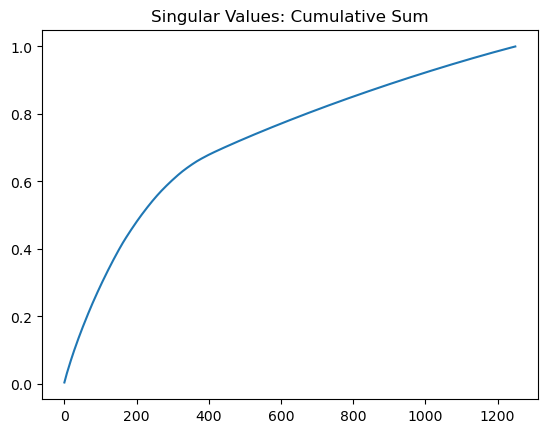

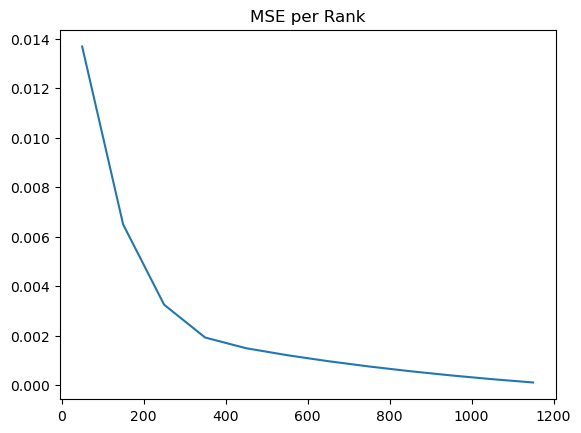

In [6]:
ranks = []
mses = []

for r in range(50, 1250, 100):
    Xapprox = reconstruct(U, S, VT, r)
    mse = np.mean((fullTrainSignalMatrix - Xapprox) ** 2)
    ranks.append(r)
    mses.append(mse)
    
plotCumSum(S)
plt.plot(ranks, mses)
plt.title('MSE per Rank')
plt.show()

with open(r"results/svd_results.csv", "a+") as f:
    for rank,mse in zip(ranks, mses):
        f.write(f"{rank},{mse}\n")

In [39]:
from scipy.linalg import qr
p = 500 # number of sensors
r = 400 # our truncated rank count
#print(f"p, r = {p}, {r}")

#reshape SVD according to r
U_hat, S_hat, VT_hat = U[:,:r], S[:r,:r], VT[:r,:]

Q, R, pivots = None, None, None

if (p == r):
    Q, R, pivots = qr(U_hat, pivoting = True) # or maybe just U
elif (p > r): # oversampled
    Q, R, pivots = qr(U_hat @ U_hat.T, pivoting = True) # or maybe just U
else:
    for _ in range(100):
        print("ERROR p < r")
pivots = pivots[:p]

# Create C matrix
C = np.zeros((p, fullTrainSignalMatrix.shape[0]))
print(f"C shape: {C.shape}")
C[np.arange(p), pivots] = 1

# print(f"U, S, VT shapes: {U_hat.shape}, {S_hat.shape}, {VT_hat.shape}")
# print(f"Q, R, pivots shapes: {Q.shape, R.shape, pivots.shape}")
# print(pivot)

C shape: (500, 1250)


In [40]:
def measureAndReconstruct(signal) -> float:
    # Measure a signal
    y = C @ signal
    
    # Solve for coefficients #CLAUDE assisted here down
    U_k_reduced = U_hat[:, :p][pivots, :]
    #print(C.shape, U_hat.shape, U_k_reduced.shape, y.shape, U_hat[:,:][pivots,:].shape)
    if p > r:
        a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
    else:
        a = np.linalg.pinv(C @ U_hat) @ y # idk how to make this work
      
    # Reconstruct the signal
    #x_reconstructed = U[:, :p] @ a
    x_reconstructed = U_hat @ a
    mseFinal = np.mean((signal - x_reconstructed) ** 2)
    return mseFinal

# for _ in range(10):
#     random_col = randint(0, len(fullTrainSignalMatrix))
#     signal = fullTrainSignalMatrix[:,random_col]
#     print(measureAndReconstruct(signal))

#catSigs = getAveragedCategorySignals()
#print(catSigs)
for label, signal in catSigs.items():
    #print(signal)
    print(label, "\tdeath\t" if label in BAD else "\tokay\t", measureAndReconstruct(signal))


AFb 	okay	 8.103666669223929e-06
AFt 	okay	 1.0396506649935725e-05
SR 	okay	 1.7415576453960208e-07
SVT 	okay	 2.7977930154412346e-06
VFb 	death	 4.078988831387206e-06
VFt 	death	 3.8533112716075424e-05
VPD 	okay	 6.929395834527444e-06
VT 	death	 5.88223844098251e-07


In [ ]:

# signal = fullTrainSignalMatrix[:,random_col]
# y = C @ signal
    
# # Solve for coefficients #CLAUDE here down
# U_k_reduced = U_hat[:, :p][pivots, :]
# a = np.linalg.lstsq(U_k_reduced, y, rcond=None)[0]
# x_reconstructed = U_hat @ a
# mseFinal = np.mean((fullTrainSignalMatrix[:,random_col] - x_reconstructed) ** 2)
# print(mseFinal)


In [ ]:
# avg_overall = getAverageSignal()
# plotSignal(len(avg_overall), avg_overall, "Overall Average")

# best = 10 # anything higher than "1" works
# keep_C = None

# # This handles the main logic loop
# for i in range(10):
#     x, s_L1, Psi, C = fourierBasis(avg_overall)
#     x_reconstructed_L1 = Psi @ s_L1

#     n = len(x)
#     plotSignal(n, x_reconstructed_L1, "L1 Reconstruction: " + str(i))

#     mse1 = np.mean((x - x_reconstructed_L1) ** 2)
#     R = correlCo(x, x_reconstructed_L1)
#     print(f"{i} MSE: {mse1} R: {R}")
#     if R < best:
#         best = R
#         keep_C = C

#     f = open(r"results\resultsFinal.txt", "a")
#     f.write(f'{mse1},{R}\n')
#     f.close()
# f = open(r"results\resultsFinal.txt", "a")
# f.write(f'{best} was the best R, that C can be saved C.pkl\n')
# f.close()

# saveObj(keep_C)